In [1]:
# Install huggingface libraries
%pip install transformers datasets huggingface_hub tensorboard torchinfo --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.30.2
Uninstalling transformers-4.30.2:
  Successfully uninstalled transformers-4.30.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 5.1 MB/s eta 0:00:00


## Library Imports

In [2]:
import torch
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from torch import nn

import datasets
from datasets import Dataset, DatasetDict
from datasets import load_metric

from transformers import Trainer, AdamW
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import BertConfig, BertForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput

from huggingface_hub import notebook_login

import torch.nn.utils.rnn as rnn_utils
from tqdm import tqdm
from prettytable import PrettyTable
from torchinfo import summary

## Set random seed

In [3]:
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        #torch.backends.cudnn.benchmark = False
        #torch.backends.cudnn.deterministic = True
    print(f'Seed {seed} has been assigned.')

SEED = 42
set_seed(SEED)

Seed 42 has been assigned.


## Torch device

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device}')

Using cuda


In [5]:
!nvidia-smi

Tue Jun 20 05:36:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dataset

In [7]:
train_path = "Corona_NLP_train.csv"
test_path = "Corona_NLP_test.csv"
train_df = pd.read_csv(train_path, encoding='ISO-8859-1')
test_df = pd.read_csv(test_path, encoding='ISO-8859-1')

In [8]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Preprocessing

### Preprocessing methods

In [9]:
#preprocess.py
def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = tweet.replace('\r', '').replace('\n', ' ').replace('\n', ' ') #Remove \n and \r
    tweet = re.sub(r'http\S+', '', tweet)       # Remove URLs
    tweet = re.sub(r'[^\x00-\x7f]',r'', tweet)  # Remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    tweet = re.sub(r'@[^\s]+', '', tweet)       # Remove usernames
    tweet = re.sub(r'\d+', '', tweet)           # Remove numbers
    tweet = re.sub("\s\s+" , " ", tweet)        # Remove multispaces
    return tweet

def remove_small_tweets(data, threshold=4, column='tweet_clean'):
    return data[data['tweet_clean'].apply(lambda x: len(x.split()) > threshold)]

def replace_labels(data):
    return data['Sentiment'].replace({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

### Preprocessing data

In [10]:
# Select only tweet text and sentiment
train_df = train_df[['OriginalTweet','Sentiment']]
test_df = test_df[['OriginalTweet','Sentiment']]

# Preprocess tweets
train_df["tweet_clean"] = train_df["OriginalTweet"].apply(preprocess_tweet)
test_df["tweet_clean"] = test_df["OriginalTweet"].apply(preprocess_tweet)

# Remove tweets with less than 5 words
train_df = remove_small_tweets(train_df)
test_df = remove_small_tweets(test_df)

# Convert categories to numbers, it considers only 3 classes
train_df['Sentiment'] = replace_labels(train_df)
test_df['Sentiment'] = replace_labels(test_df)

<ipython-input-10-c874411ca0e4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Sentiment'] = replace_labels(train_df)
<ipython-input-10-c874411ca0e4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Sentiment'] = replace_labels(test_df)


In [11]:
train_df.head()

,OriginalTweet,Sentiment,tweet_clean
1,advice Talk to your neighbours family to excha...,2,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia: woolworths to give elde...
3,My food stock is not the only one which is emp...,2,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",0,"me, ready to go at supermarket during the #cov..."
5,As news of the regionÂs first confirmed COVID...,2,as news of the regions first confirmed covid- ...


## Train values

In [12]:
X_train_total = train_df['tweet_clean'].values
y_train_total = train_df['Sentiment'].values

print(f'Train size: {X_train_total.shape}')

Train size: (40962,)


## Data partitioning

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=0.2, stratify=y_train_total, random_state=SEED)

In [14]:
print(f'Train size: {X_train.shape}')
print(f'Validation size: {X_val.shape}')

Train size: (32769,)
Validation size: (8193,)


## Dataset preparation

In [15]:
# Train data
train_df = pd.DataFrame(list(zip(X_train, y_train)), columns = ['tweet_clean', 'labels'])
# Validation data
val_df = pd.DataFrame(list(zip(X_val, y_val)), columns = ['tweet_clean', 'labels'])
# Test data
test_df = test_df.rename(columns={"Sentiment":"labels"})
test_df = test_df[["tweet_clean", "labels"]]

### Huggingface datasets

In [16]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)
test_ds = test_ds.remove_columns(["__index_level_0__"])

In [17]:
dataset = DatasetDict()

dataset['train'] = train_ds
dataset['validation'] = val_ds
dataset['test'] = test_ds

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['tweet_clean', 'labels'],
        num_rows: 32769
    })
    validation: Dataset({
        features: ['tweet_clean', 'labels'],
        num_rows: 8193
    })
    test: Dataset({
        features: ['tweet_clean', 'labels'],
        num_rows: 3793
    })
})


## Teacher model name

In [18]:
teacher_id = "Moniksama/finetuned-bert-covid-tweets"

In [19]:
# Configuration file of the teacher model
config_bert = BertConfig.from_pretrained(teacher_id)
config_bert

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Tokenization

In [20]:
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

In [21]:
MAX_LENGTH = 100
def tokenize_data(sample):
    return tokenizer(sample["tweet_clean"], max_length=MAX_LENGTH, padding='max_length', truncation=True, return_length=True)
    #return tokenizer(sample["tweet_clean"], max_length=MAX_LENGTH, truncation=True, return_length=True)
tokenized_dataset = dataset.map(tokenize_data, batched=True)

# Remove text column, now we have it tokenized
tokenized_dataset = tokenized_dataset.remove_columns(["tweet_clean"])

# Separate each dataset
train_ds = tokenized_dataset['train']
val_ds = tokenized_dataset['validation']
test_ds = tokenized_dataset['test']

Map:   0%|          | 0/32769 [00:00<?, ? examples/s]

Map:   0%|          | 0/8193 [00:00<?, ? examples/s]

Map:   0%|          | 0/3793 [00:00<?, ? examples/s]

## Evaluation metrics

In [22]:
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric('f1')
precision_metric = load_metric('precision')
recall_metric = load_metric('recall')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    # metrics
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {"accuracy": acc["accuracy"],
            "f1-score": f1["f1"],
            "precision": precision["precision"],
            "recall": recall["recall"]}

<ipython-input-22-607060562a56>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


In [23]:
def get_runtime(results):
    runtime = results['eval_runtime']
    mins, secs = int(runtime//60), int(runtime % 60)
    runtime_str = "{}m {}s".format(mins, secs)
    return runtime_str

def get_metrics_train_val(train_results, val_results):
    return [train_results['eval_accuracy'], val_results['eval_accuracy'],
            train_results['eval_f1-score'], val_results['eval_f1-score']]

def get_metrics_test(test_results):
    return [test_results['eval_accuracy'], test_results['eval_f1-score']]




In [24]:
def get_train_val_history(trainer):
    # Access to train and validation history loss per epoch
    log_history = trainer.state.log_history
    train_history, valid_history = [], []

    for cur_dict in log_history:
        if 'epoch' in cur_dict and (int(cur_dict['epoch']) == cur_dict['epoch'] or cur_dict['step'] % 1000 == 0):
            if 'loss' in cur_dict:
                train_history.append(cur_dict['loss'])
            elif 'eval_loss' in cur_dict:
                valid_history.append(cur_dict['eval_loss'])

            if len(valid_history) > len(train_history):
                valid_history = valid_history[:-1]
                break
    return train_history, valid_history

import matplotlib.pyplot as plt
def plot_learning_curve(train_history, val_history, title=''):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(train_history, label='Training loss')
    ax.plot(val_history, label='Validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    if len(title) > 0:
        ax.set_title(title + ' loss history')
    ax.legend()
    ax.grid()
    plt.show()

## Training BiLSTM

### Data collator

In [ ]:
def collate_fn(batch):
    # Extract the input sequences and labels from the batch
    input_ids = [sample['input_ids'] for sample in batch]
    labels = [sample['labels'] for sample in batch]
    # Calculate true lengths using the attention mask
    lengths = [sum(sample['attention_mask']) for sample in batch]
    #attention_masks = [sample['attention_mask'] for sample in batch]

    # Convert lists to tensors
    #input_ids = torch.stack(input_ids, dim=0)
    input_ids = torch.tensor(input_ids)
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    # Sort the sequences by length in descending order
    lengths_sorted, sorted_indices = torch.sort(lengths, descending=True)
    inputs_sorted = input_ids[sorted_indices]
    labels_sorted = labels[sorted_indices]

    return { 'length': lengths_sorted, 'labels': labels_sorted, 'input_ids': inputs_sorted}

### Model

In [25]:
class RNNModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_classes, hidden_size,
                       num_layers=1, net_type='rnn', bidirectional=False,
                       dropout=0, use_pooling=False, device="cpu"):
        super().__init__()
        self.net_type = net_type
        self.use_pooling = use_pooling
        self.num_classes = num_classes

        # Embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)

        # RNN
        if net_type == 'lstm':
            self.cell = nn.LSTM(embed_size, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        elif net_type == 'gru':
            self.cell = nn.GRU(embed_size, hidden_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        else:
            raise ValueError("Invalir net_type. Valid options: lstm and gru")
        if bidirectional:
            hidden_size *= 2

        # classifier
        #self.classifier = nn.Sequential(
        #    nn.Linear(hidden_size, hidden_size//2),
        #    nn.ReLU(),
        #    nn.Dropout(dropout),
        #    nn.Linear(hidden_size//2, num_classes)
        #)
        self.classifier = nn.Linear(hidden_size, num_classes)

        # Regularizer
        self.dropout = nn.Dropout(dropout)

        # Required by huggingface
        self.device = device


    def forward(self, input_ids, length, labels=None):
        #labels are required to compute loss in huggingface (used in evaluation phase)
        X = self.word_embeddings(input_ids) #[batch_size, seq_len, embed_size]
        X = self.dropout(X)

        # Forward without considering padding
        packed_inputs = rnn_utils.pack_padded_sequence(X, length.to('cpu'), batch_first=True)
        output_packed, _ = self.cell(packed_inputs)
        outputs, output_lengths = rnn_utils.pad_packed_sequence(output_packed, batch_first=True,padding_value=-10000) #outputs -> [batch_size, seq_len, 2*hidden_size])

        if self.use_pooling:
            # Max pooling of all the output vectors
            out = outputs.max(1)[0]
        else:
            # First output vector (CLS vector)
            out = outputs[:,0,:]

        # Logits
        logits = self.classifier(out)

        # Based on huggingface source
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.num_classes), labels.view(-1))

        # Huggingface models require a specific output
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states = None,
            attentions=None
        )

### Training arguments

In [ ]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

batch_size = 32
num_epochs = 10
lr = 5e-3
embed_size = 128
num_classes = 3
vocab_size = config_bert.vocab_size
hidden_size = 128 #hidden_size in rnn
dropout = 0.5
weight_decay = 1e-3
net_type="lstm" #"gru"
rnn_model = RNNModel(embed_size, vocab_size, num_classes, hidden_size,
                     num_layers=1, net_type=net_type, bidirectional=True,
                     dropout=dropout,use_pooling=True, device=device)


# name for the repository on the hub
repo_name = "distilled-bert-covid-tweets"

#!pip install --upgrade accelerate
training_args = TrainingArguments(output_dir=repo_name,
                                  num_train_epochs = num_epochs,
                                  evaluation_strategy ="epoch",
                                  save_strategy = "epoch",
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  learning_rate = lr,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  fp16=True,
                                  weight_decay=weight_decay,
                                  #push_to_hub=True,
                                  #hub_model_id=repo_name,
                                  remove_unused_columns=False,
                                  model_type="lstm",
                                  distil_loss='kl',
                                  lr_scheduler_type ='constant'
                                  )

In [ ]:
trainer = Trainer(
    rnn_model,
    training_args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [ ]:
results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,0.720700,0.607629,0.773343,0.774703,0.780614,0.773343
2,0.539600,0.513701,0.826559,0.827142,0.830169,0.826559
3,0.460700,0.497079,0.839741,0.839258,0.845104,0.839741
4,0.396100,0.445721,0.860247,0.860354,0.860597,0.860247
5,0.355000,0.426156,0.867570,0.867388,0.867609,0.867570
6,0.316900,0.415221,0.872818,0.872531,0.872605,0.872818
7,0.293700,0.416485,0.874771,0.874481,0.874563,0.874771
8,0.274000,0.414023,0.875870,0.875559,0.875687,0.875870
9,0.261300,0.415425,0.877212,0.876720,0.877211,0.877212
10,0.240700,0.411057,0.878555,0.878147,0.878485,0.878555


#### Methods to show summary of results

In [26]:
def print_table(headers, values):
    table = PrettyTable(headers)
    for i in values:
        table.add_row(i)
    table.float_format = '.3'
    print(table)

def add_results(name, ckp_results):
    return [name, ckp_results['train_loss'], ckp_results['val_loss'],
                  ckp_results['train_acc'], ckp_results['val_acc'] ]

def total_num_parameters(model, millions=True, model_name='lstm'):
    if model_name == 'bert':
        num_parameters = model.num_parameters()
    else:
        num_parameters = sum(p.numel() for p in model.parameters())

    suffix = ''
    if millions:
        num_parameters /= 1e6
        suffix = 'M'
    output = "{:.2f} " + suffix
    return output.format(num_parameters)

In [ ]:
print_table(["Model", "Parameters"], [ \
            ['BiLSTM', total_num_parameters(rnn_model)]
           ])

+--------+------------+
| Model  | Parameters |
+--------+------------+
| BiLSTM |   4.17 M   |
+--------+------------+


## Distillation

### Data collator

In [27]:
def distill_lstm_collate_fn(batch):
    # Extract the input sequences and labels from the batch
    input_ids = [sample['input_ids'] for sample in batch]
    labels = [sample['labels'] for sample in batch]
    # Calculate true lengths using the attention mask
    lengths = [sum(sample['attention_mask']) for sample in batch]
    # Attention masks used by the teacher
    attention_masks = [sample['attention_mask'] for sample in batch]

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)
    attention_masks = torch.tensor(attention_masks)

    # Sort the sequences by length in descending order
    lengths_sorted, sorted_indices = torch.sort(lengths, descending=True)
    inputs_sorted = input_ids[sorted_indices]
    labels_sorted = labels[sorted_indices]

    return { 'length': lengths_sorted, 'labels': labels_sorted, 'input_ids': inputs_sorted, 'attention_mask': attention_masks}

### Custom trainer

In [28]:
import torch.nn.functional as F

class Losses():
    def distillation_loss_mse(self, student_logits, teacher_logits):
        loss = F.mse_loss(student_logits, teacher_logits)
        return loss

    def distillation_loss_kl(self, student_logits, teacher_logits, temperature=1):
        student_log_probs = F.log_softmax(student_logits / temperature, dim=-1)
        teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
        loss = F.kl_div(student_log_probs, teacher_probs.detach(),
                        reduction='batchmean') * (temperature**2)

        #student_probs = F.softmax(student_logits / temperature, dim=-1)
        #teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)
        #loss = F.kl_div(student_probs.log(), teacher_probs.detach(), reduction='batchmean')
        return loss

In [29]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, model_type=None, distil_loss='mse',**kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature
        self.model_type=model_type
        self.distil_loss = distil_loss

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        # place teacher on same device as student
        self._move_model_to_device(self.teacher, self.model.device)
        self.teacher.eval()
        self.losses = Losses()

    def compute_loss(self, model, inputs, return_outputs=False):
        # Student forward
        if self.args.model_type == "lstm":
          outputs_student = model(inputs['input_ids'], inputs['length'], inputs['labels'])
        elif self.args.model_type == "smallbert":
          student_inputs = {'input_ids': inputs['input_ids'], 'attention_mask':inputs['attention_mask'], 'labels':inputs['labels']}
          outputs_student = model(**student_inputs)
        else:
          outputs_student = model(inputs['input_ids'], inputs['labels'])
        student_loss = outputs_student.loss
        student_logits = outputs_student.get("logits")

        #if self.args.alpha == 1.0:
          # Weighted loss
          #loss = self.args.alpha * student_loss + (1. - self.args.alpha) * kl_loss

          #return (loss, outputs_student) if return_outputs else loss
        #else:
        # Teacher forward
        with torch.no_grad():
          teacher_inputs = {'input_ids': inputs['input_ids'], 'attention_mask':inputs['attention_mask'], 'labels':inputs['labels'] }
          outputs_teacher = self.teacher(**teacher_inputs)
        teacher_logits = outputs_teacher.get("logits")

        # Assert size
        assert student_logits.size() == teacher_logits.size()

        # Distillation Loss
        if self.args.distil_loss == 'mse':
          kl_loss = self.losses.distillation_loss_mse(student_logits,teacher_logits)
        elif self.args.distil_loss == 'kl':
          kl_loss = self.losses.distillation_loss_kl(student_logits, teacher_logits, self.args.temperature)
        else:
          raise RuntimeError("Unknown distillation loss: {}, only supported: mse and kl".format(self.args.distil_loss))

        # Weighted loss
        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * kl_loss

        return (loss, outputs_student) if return_outputs else loss

## Cross-Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import copy

def cross_validate(input_model, teacher_model, train_total_ds,
                   num_splits, training_args, tokenizer, collate_fn=None):
    kf= StratifiedKFold(n_splits=5)
    #kf = KFold(n_splits=num_splits, shuffle=True)
    #cv_scores = {"train_loss":[], "val_loss":[],
    #             "train_acc":[], "val_acc":[],
    #             "train_f1":[], "val_f1":[]}
    cv_scores = {'train': {}, 'val':{}}
    splits = kf.split(np.zeros(train_total_ds.num_rows), train_total_ds['labels'])
    for i, (train_indices, val_indices) in enumerate(splits):
        train_ds = train_total_ds.select(train_indices)
        val_ds = train_total_ds.select(val_indices)

        student_model = copy.deepcopy(input_model)
        trainer_distillation = DistillationTrainer(
            student_model,
            training_args,
            teacher_model=teacher_model,
            train_dataset = train_ds,
            eval_dataset = val_ds,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            data_collator=collate_fn
        )
        print(f"Fold: ({i+1}/{num_splits})")
        results = trainer_distillation.train()
        print()

        results_train = trainer_distillation.evaluate(train_ds)
        results_val = trainer_distillation.evaluate(val_ds)

        for key, value in results_train.items():
            if key in cv_scores['train']:
                cv_scores['train'][key].append(value)
            else:
                cv_scores['train'][key] = [value]

        for key, value in results_val.items():
            if key in cv_scores['val']:
                cv_scores['val'][key].append(value)
            else:
                cv_scores['val'][key] = [value]
    return cv_scores

### Training arguments BiLSTM


In [30]:
batch_size = 32
num_epochs = 7
lr = 5e-3
embed_size = 128
num_classes = 3
vocab_size = config_bert.vocab_size
hidden_size = 128 #hidden_size in rnn
dropout = 0.2
weight_decay = 1e-3
net_type="lstm" #"gru"

temperature=4.0
alpha=0.5

student_rnn_model = RNNModel(embed_size, vocab_size, num_classes, hidden_size,
                         num_layers=1, net_type=net_type, bidirectional=True,
                         dropout=dropout,use_pooling=True, device=device)
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_id)


# name for the repository on the hub
repo_name = "distilled-bert-covid-tweets"

#!pip install --upgrade accelerate
training_args = DistillationTrainingArguments(output_dir=repo_name,
                                              num_train_epochs = num_epochs,
                                              evaluation_strategy ="epoch",
                                              save_strategy = "epoch",
                                              per_device_train_batch_size = batch_size,
                                              per_device_eval_batch_size = batch_size,
                                              learning_rate = lr,
                                              load_best_model_at_end=True,
                                              metric_for_best_model="accuracy",
                                              fp16=True,
                                              weight_decay=weight_decay,
                                              #push_to_hub=True,
                                              #hub_model_id=repo_name,
                                              temperature=temperature,
                                              alpha=alpha,
                                              remove_unused_columns=False,
                                              model_type="lstm",
                                              distil_loss='kl',
                                              lr_scheduler_type ='constant'
                                              )

In [31]:
trainer_distillation = DistillationTrainer(
    student_rnn_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=distill_lstm_collate_fn
)

##For alpha = 0.5 and T = 4.0

In [32]:
results_distillation_lstm = trainer_distillation.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,1.517400,1.300430,0.814964,0.815564,0.818606,0.814964
2,1.046000,1.055243,0.851703,0.851969,0.854515,0.851703
3,0.883300,0.946826,0.857561,0.857190,0.859751,0.857561
4,0.807800,0.926623,0.869035,0.868655,0.870357,0.869035


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,1.517400,1.300430,0.814964,0.815564,0.818606,0.814964
2,1.046000,1.055243,0.851703,0.851969,0.854515,0.851703
3,0.883300,0.946826,0.857561,0.857190,0.859751,0.857561
4,0.807800,0.926623,0.869035,0.868655,0.870357,0.869035
5,0.750800,0.879030,0.883193,0.882906,0.883111,0.883193
6,0.714100,0.918887,0.880996,0.880467,0.881170,0.880996
7,0.703000,0.876137,0.880874,0.880695,0.880756,0.880874


In [ ]:
# Results after training
train_results = trainer_distillation.evaluate(train_ds)
val_results = trainer_distillation.evaluate(val_ds)

# Summary of CNN results
rnn_num_params = total_num_parameters(student_rnn_model)
print_table(["Model", "Train ACC", "Val ACC", "Train F1", "Val F1", "Parameters", "Val Runtime"], [ \
            ['Small RNN', *get_metrics_train_val(train_results, val_results), rnn_num_params, get_runtime(val_results)]
           ])

+-----------+-----------+---------+----------+--------+------------+-------------+
|   Model   | Train ACC | Val ACC | Train F1 | Val F1 | Parameters | Val Runtime |
+-----------+-----------+---------+----------+--------+------------+-------------+
| Small RNN |   0.954   |  0.875  |  0.954   | 0.875  |   4.17 M   |    0m 46s   |
+-----------+-----------+---------+----------+--------+------------+-------------+


In [33]:
# Test data
test_results = trainer_distillation.evaluate(test_ds)

# Summary of LSTM results for Test data
rnn_num_params = total_num_parameters(student_rnn_model)
print_table(["Model", "Test ACC", "Test F1", "Parameters", "Test Runtime"], [ \
            ['Small RNN', *get_metrics_test(test_results), rnn_num_params, get_runtime(test_results)]
           ])

+-----------+----------+---------+------------+--------------+
|   Model   | Test ACC | Test F1 | Parameters | Test Runtime |
+-----------+----------+---------+------------+--------------+
| Small RNN |  0.875   |  0.875  |   4.17 M   |    0m 22s    |
+-----------+----------+---------+------------+--------------+


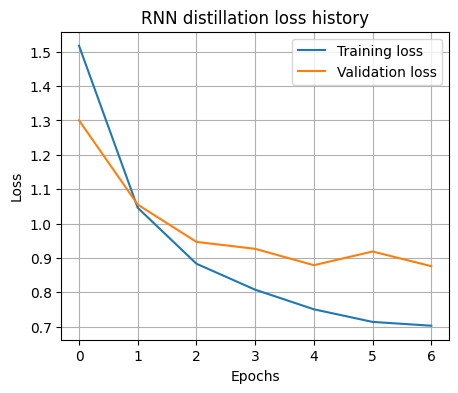

In [34]:
train_history, val_history = get_train_val_history(trainer_distillation)
plot_learning_curve(train_history, val_history, 'RNN distillation')

In [ ]:
print_table(["Model", "Parameters"], [ \
            ['BERT base', total_num_parameters(teacher_model, model_name='bert')],
            ['BiLSTM', total_num_parameters(student_rnn_model)]
           ])

+-----------+------------+
|   Model   | Parameters |
+-----------+------------+
| BERT base |  109.48 M  |
|   BiLSTM  |   4.17 M   |
+-----------+------------+


##For alpha = 0 and T = 4.0

In [ ]:
results_distillation_lstm1 = trainer_distillation.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,2.391300,2.025536,0.798242,0.798578,0.800044,0.798242
2,1.674200,1.620056,0.839863,0.840348,0.844032,0.839863
3,1.466500,1.493854,0.844868,0.844982,0.845219,0.844868
4,1.361000,1.545432,0.848529,0.848065,0.850947,0.848529
5,1.281800,1.422119,0.854144,0.853999,0.854584,0.854144
6,1.244100,1.416365,0.857805,0.857668,0.857665,0.857805
7,1.210000,1.385518,0.858416,0.858254,0.858829,0.858416


In [ ]:
# Results after training
train_results = trainer_distillation.evaluate(train_ds)
val_results = trainer_distillation.evaluate(val_ds)

# Summary of LSTM results
rnn_num_params = total_num_parameters(student_rnn_model)
print_table(["Model", "Train ACC", "Val ACC", "Train F1", "Val F1", "Parameters", "Val Runtime"], [ \
            ['Small RNN', *get_metrics_train_val(train_results, val_results), rnn_num_params, get_runtime(val_results)]
           ])

In [ ]:
# Test data
test_results1 = trainer_distillation.evaluate(test_ds)

# Summary of LSTM results for Test data
rnn_num_params1 = total_num_parameters(student_rnn_model)
print_table(["Model", "Test ACC", "Test F1", "Parameters", "Test Runtime"], [ \
            ['Small RNN', *get_metrics_test(test_results1), rnn_num_params1, get_runtime(test_results1)]
           ])

+-----------+----------+---------+------------+--------------+
|   Model   | Test ACC | Test F1 | Parameters | Test Runtime |
+-----------+----------+---------+------------+--------------+
| Small RNN |  0.856   |  0.856  |   4.17 M   |    0m 22s    |
+-----------+----------+---------+------------+--------------+


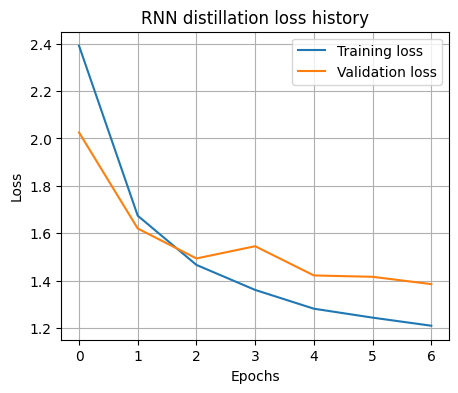

In [ ]:
train_history, val_history = get_train_val_history(trainer_distillation)
plot_learning_curve(train_history, val_history, 'RNN distillation')

##For alpha = 1.0 and T = 1

In [ ]:
results_distillation_lstm2 = trainer_distillation.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,0.582200,0.561471,0.798487,0.797155,0.811972,0.798487
2,0.404900,0.455167,0.849262,0.849190,0.855588,0.849262
3,0.306800,0.406514,0.869523,0.869282,0.869522,0.869523
4,0.240300,0.415437,0.874405,0.874022,0.874269,0.874405
5,0.191800,0.456171,0.867326,0.866942,0.867546,0.867326
6,0.168700,0.504258,0.870743,0.870308,0.872478,0.870743
7,0.142500,0.511762,0.868546,0.868330,0.868503,0.868546


In [ ]:
# Results after training
train_results = trainer_distillation.evaluate(train_ds)
val_results = trainer_distillation.evaluate(val_ds)

# Summary of LSTM results
rnn_num_params = total_num_parameters(student_rnn_model)
print_table(["Model", "Train ACC", "Val ACC", "Train F1", "Val F1", "Parameters", "Val Runtime"], [ \
            ['Small RNN', *get_metrics_train_val(train_results, val_results), rnn_num_params, get_runtime(val_results)]
           ])

In [ ]:
# Test data
test_results3 = trainer_distillation.evaluate(test_ds)

# Summary of LSTM results for Test data
rnn_num_params3 = total_num_parameters(student_rnn_model)
print_table(["Model", "Test ACC", "Test F1", "Parameters", "Test Runtime"], [ \
            ['Small RNN', *get_metrics_test(test_results3), rnn_num_params3, get_runtime(test_results3)]
           ])

+-----------+----------+---------+------------+--------------+
|   Model   | Test ACC | Test F1 | Parameters | Test Runtime |
+-----------+----------+---------+------------+--------------+
| Small RNN |  0.859   |  0.859  |   4.17 M   |    0m 22s    |
+-----------+----------+---------+------------+--------------+


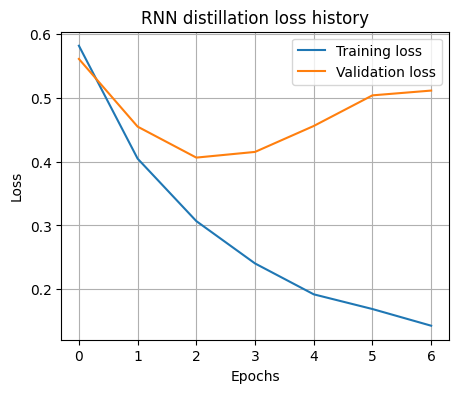

In [ ]:
train_history, val_history = get_train_val_history(trainer_distillation)
plot_learning_curve(train_history, val_history, 'RNN distillation')

## Distillation to BERT

### Student model (Smaller version of BERT)

In [ ]:
# Configuration file of the teacher model
config_small_bert = BertConfig.from_pretrained(teacher_id)
config_small_bert

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### BERT with three encoder layers

We modify the configuration to obtain a smaller version of BERT

In [ ]:
# Student with 3 hidden layers
config_small_bert.num_hidden_layers = 3
config_small_bert.hidden_size = 128
config_small_bert.num_attention_heads = 2
config_small_bert.intermediate_size = 512

In [ ]:
config_small_bert

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
#student_model = BertForSequenceClassification(config=config_bert)

### Training arguments

In [ ]:
batch_size = 32
num_epochs = 3
lr = 1e-3
num_classes = 3
weight_decay = 0.5

# Student
config_bert.num_hidden_layers = 3
config_bert.hidden_size = 128
config_bert.num_attention_heads = 2
config_bert.intermediate_size = 512

temperature=1.0
alpha=1.0

student_model_bert = BertForSequenceClassification(config=config_bert)
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_id)

# name for the repository on the hub
repo_name = "distilled-bert-covid-tweets"

training_args = DistillationTrainingArguments(output_dir=repo_name,
                                              num_train_epochs = num_epochs,
                                              evaluation_strategy ="epoch",
                                              save_strategy = "epoch",
                                              per_device_train_batch_size = batch_size,
                                              per_device_eval_batch_size = batch_size,
                                              learning_rate = lr,
                                              load_best_model_at_end=True,
                                              metric_for_best_model="accuracy",
                                              fp16=True,
                                              weight_decay=weight_decay,
                                              #push_to_hub=True,
                                              #hub_model_id=repo_name,
                                              temperature=temperature,
                                              alpha=alpha,
                                              remove_unused_columns=False,
                                              model_type="smallbert",
                                              distil_loss='kl',
                                              #lr_scheduler_type ='constant'
                                              )

In [ ]:
trainer_distillation_bert = DistillationTrainer(
    student_model_bert,
    training_args,
    teacher_model=teacher_model,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
print_table(["Model", "Parameters"], [ \
            ['BERT base', total_num_parameters(teacher_model, model_name='bert')],
            ['BiLSTM', total_num_parameters(student_rnn_model)],
            ['Small BERT', total_num_parameters(student_model_bert, model_name='bert')]
           ])

+------------+------------+
|   Model    | Parameters |
+------------+------------+
| BERT base  |  109.48 M  |
|   BiLSTM   |   9.00 M   |
| Small BERT |   4.58 M   |
+------------+------------+


##For alpha = 0.5 and T = 4

In [ ]:
results_distillation_bert = trainer_distillation_bert.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,1.942700,1.374471,0.780788,0.780769,0.783943,0.780788
2,0.993800,0.899592,0.848407,0.847963,0.848844,0.848407
3,0.584600,0.861634,0.849262,0.848376,0.849450,0.849262


In [ ]:
# Test data
test_results_bert1 = trainer_distillation_bert.evaluate(test_ds)

# Summary of LSTM results for Test data
bert_num_params1 = total_num_parameters(student_model_bert)
print_table(["Model", "Test ACC", "Test F1", "Parameters", "Test Runtime"], [ \
            ['Small RNN', *get_metrics_test(test_results_bert1), bert_num_params1, get_runtime(test_results_bert1)]
           ])

+-----------+----------+---------+------------+--------------+
|   Model   | Test ACC | Test F1 | Parameters | Test Runtime |
+-----------+----------+---------+------------+--------------+
| Small RNN |  0.830   |  0.830  |   4.58 M   |    0m 22s    |
+-----------+----------+---------+------------+--------------+


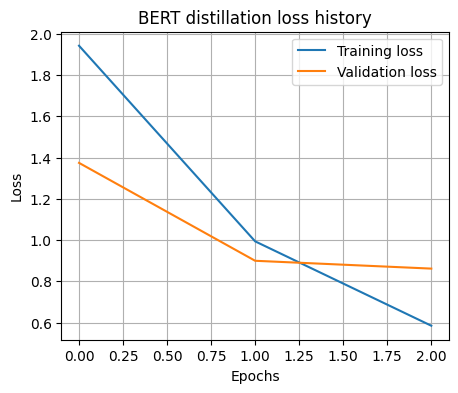

In [ ]:
train_history, val_history = get_train_val_history(trainer_distillation_bert)
plot_learning_curve(train_history, val_history, 'BERT distillation')

##For alpha = 0.0 and T = 4

In [ ]:
results_distillation_bert2 = trainer_distillation_bert.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,3.478600,2.370097,0.738679,0.736605,0.743957,0.738679
2,1.476900,1.205957,0.847919,0.847570,0.847484,0.847919
3,0.847400,1.112556,0.854266,0.853435,0.854258,0.854266


In [ ]:
# Test data
test_results_bert2 = trainer_distillation_bert.evaluate(test_ds)

# Summary of LSTM results for Test data
bert_num_params2 = total_num_parameters(student_model_bert)
print_table(["Model", "Test ACC", "Test F1", "Parameters", "Test Runtime"], [ \
            ['Small RNN', *get_metrics_test(test_results_bert2), bert_num_params2, get_runtime(test_results_bert2)]
           ])

+-----------+----------+---------+------------+--------------+
|   Model   | Test ACC | Test F1 | Parameters | Test Runtime |
+-----------+----------+---------+------------+--------------+
| Small RNN |  0.840   |  0.839  |   4.58 M   |    0m 21s    |
+-----------+----------+---------+------------+--------------+


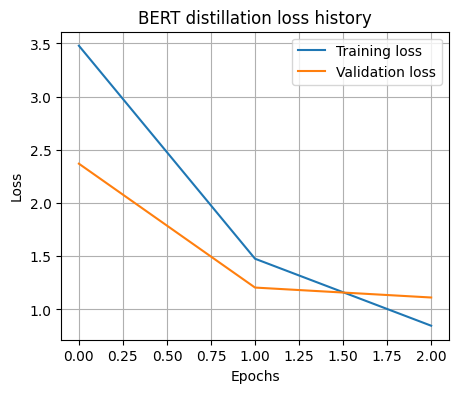

In [ ]:
train_history, val_history = get_train_val_history(trainer_distillation_bert)
plot_learning_curve(train_history, val_history, 'BERT distillation')

##For alpha = 1.0 and T = 1.0

In [ ]:
results_distillation_bert3 = trainer_distillation_bert.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,0.610400,0.547537,0.800806,0.800231,0.809103,0.800806
2,0.396000,0.440541,0.847431,0.846446,0.847828,0.847431
3,0.239900,0.472848,0.852069,0.851189,0.852407,0.852069


In [ ]:
# Test data
test_results_bert3 = trainer_distillation_bert.evaluate(test_ds)

# Summary of LSTM results for Test data
bert_num_params3 = total_num_parameters(student_model_bert)
print_table(["Model", "Test ACC", "Test F1", "Parameters", "Test Runtime"], [ \
            ['Small RNN', *get_metrics_test(test_results_bert3), bert_num_params3, get_runtime(test_results_bert3)]
           ])

+-----------+----------+---------+------------+--------------+
|   Model   | Test ACC | Test F1 | Parameters | Test Runtime |
+-----------+----------+---------+------------+--------------+
| Small RNN |  0.835   |  0.835  |   4.58 M   |    0m 21s    |
+-----------+----------+---------+------------+--------------+


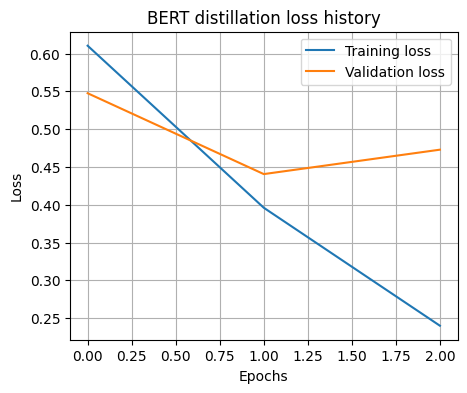

In [ ]:
train_history, val_history = get_train_val_history(trainer_distillation_bert)
plot_learning_curve(train_history, val_history, 'BERT distillation')

## Training 1D CNN

### Data collator

In [ ]:
def collate_fn_cnn(batch):
    # Extract the input sequences and labels from the batch
    input_ids = [sample['input_ids'] for sample in batch]
    labels = [sample['labels'] for sample in batch]
    input_ids = torch.tensor(input_ids)
    labels = torch.tensor(labels)
    return { 'input_ids': input_ids, 'labels': labels}

### Model

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_classes, dropout=0, device="cpu"):
        super().__init__()
        self.num_classes = num_classes
        # Required by huggingface
        self.device = device

        self.embeddings = nn.Embedding(vocab_size, embed_size)

        self.feat = nn.Sequential(
            nn.Conv1d(embed_size, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, labels=None):
        X = self.embeddings(input_ids)
        X = self.dropout(X)

        out = self.feat(X.permute(0, 2, 1))
        out = self.dropout(out)

        logits = self.classifier(out)

        # Based on huggingface source
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.num_classes), labels.view(-1))

        # Huggingface models require a specific output
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states = None,
            attentions=None
        )

### Training arguments

In [ ]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F


vocab_size = config_bert.vocab_size
embed_size = 128#64
num_classes = 3
dropout = 0.2
batch_size = 32
num_epochs = 10
lr = 1e-3
weight_decay = 1e-3

cnn_model = CNNModel(embed_size, vocab_size, num_classes, dropout, device)

# name for the repository on the hub
repo_name = "cnn_sentiment_analysis"

#!pip install --upgrade accelerate
training_args = TrainingArguments(output_dir=repo_name,
                                  num_train_epochs = num_epochs,
                                  evaluation_strategy ="epoch",
                                  save_strategy = "epoch",
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  learning_rate = lr,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  fp16=True,
                                  weight_decay=weight_decay,
                                  #push_to_hub=True,
                                  #hub_model_id=repo_name,
                                  remove_unused_columns=False,
                                  report_to="wandb"
                                  )

In [ ]:
cnn_trainer = Trainer(
    cnn_model,
    training_args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=collate_fn_cnn
)

In [ ]:
cnn_results = cnn_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,0.871100,0.813533,0.629318,0.616014,0.629372,0.629318
2,0.740100,0.705096,0.707311,0.706462,0.706594,0.707311
3,0.641400,0.639836,0.747223,0.747490,0.750196,0.747223
4,0.576900,0.591361,0.772489,0.773264,0.774755,0.772489
5,0.523000,0.569940,0.786159,0.786652,0.788079,0.786159
6,0.482100,0.550665,0.799463,0.799562,0.799682,0.799463
7,0.458400,0.547063,0.804833,0.804784,0.804776,0.804833
8,0.430300,0.543066,0.808251,0.808680,0.809367,0.808251
9,0.413500,0.540371,0.810448,0.810291,0.810192,0.810448
10,0.385000,0.538596,0.814110,0.814439,0.814912,0.814110


In [ ]:
cnn_trainer.evaluate(train_ds)

In [ ]:
cnn_trainer.evaluate(val_ds)

#### Summary of results

In [ ]:
print_table(["Model", "Parameters"], [ \
            ['CNN 1D', total_num_parameters(cnn_model)]
           ])

+--------+------------+
| Model  | Parameters |
+--------+------------+
| CNN 1D |   3.93 M   |
+--------+------------+


## Distillation to CNN

### Data collator

In [ ]:
def distill_cnn_collate_fn(batch):
    # Extract the input sequences and labels from the batch
    input_ids = [sample['input_ids'] for sample in batch]
    labels = [sample['labels'] for sample in batch]
    # Attention masks used by the teacher
    attention_masks = [sample['attention_mask'] for sample in batch]

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    labels = torch.tensor(labels)
    attention_masks = torch.tensor(attention_masks)

    return { 'labels': labels, 'input_ids': input_ids, 'attention_mask': attention_masks}

### Training arguments

In [ ]:
vocab_size = config_bert.vocab_size
#embed_size = 64
embed_size = 128
num_classes = 3
dropout = 0.2
batch_size = 32
num_epochs = 7
lr = 5e-3
weight_decay = 1e-3

temperature=1.0
alpha=1.0

cnn_student_model = CNNModel(embed_size, vocab_size, num_classes, dropout, device)

teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_id)


# name for the repository on the hub
repo_name = "distilled-bert-covid-tweets"

#!pip install --upgrade accelerate
training_args = DistillationTrainingArguments(output_dir=repo_name,
                                              num_train_epochs = num_epochs,
                                              evaluation_strategy ="epoch",
                                              save_strategy = "epoch",
                                              per_device_train_batch_size = batch_size,
                                              per_device_eval_batch_size = batch_size,
                                              learning_rate = lr,
                                              load_best_model_at_end=True,
                                              metric_for_best_model="accuracy",
                                              fp16=True,
                                              weight_decay=weight_decay,
                                              #push_to_hub=True,
                                              #hub_model_id=repo_name,
                                              temperature=temperature,
                                              alpha=alpha,
                                              model_type="cnn",
                                              remove_unused_columns=False,
                                              distil_loss='kl',
                                              lr_scheduler_type ='constant'
                                              )

In [ ]:
trainer_distillation = DistillationTrainer(
    cnn_student_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=distill_cnn_collate_fn
)

##For alpha = 0.5 and T = 4.0

In [ ]:
results_distillation_cnn1 = trainer_distillation.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,1.844700,1.583392,0.763701,0.761342,0.777573,0.763701
2,1.335400,1.133475,0.840596,0.840743,0.842147,0.840596
3,1.121700,1.003116,0.839009,0.837987,0.847333,0.839009
4,0.998400,0.932954,0.849384,0.848715,0.852065,0.849384
5,0.889000,0.866598,0.863420,0.862952,0.864972,0.863420
6,0.813500,0.871782,0.865129,0.865140,0.865153,0.865129
7,0.760200,0.866686,0.856707,0.855950,0.860314,0.856707


In [ ]:
# Test data
test_results_cnn1 = trainer_distillation.evaluate(test_ds)

# Summary of LSTM results for Test data
cnn_num_params1 = total_num_parameters(cnn_student_model)
print_table(["Model", "Test ACC", "Test F1", "Parameters", "Test Runtime"], [ \
            ['Small RNN', *get_metrics_test(test_results_cnn1), cnn_num_params1, get_runtime(test_results_cnn1)]
           ])

+-----------+----------+---------+------------+--------------+
|   Model   | Test ACC | Test F1 | Parameters | Test Runtime |
+-----------+----------+---------+------------+--------------+
| Small RNN |  0.860   |  0.860  |   3.93 M   |    0m 21s    |
+-----------+----------+---------+------------+--------------+


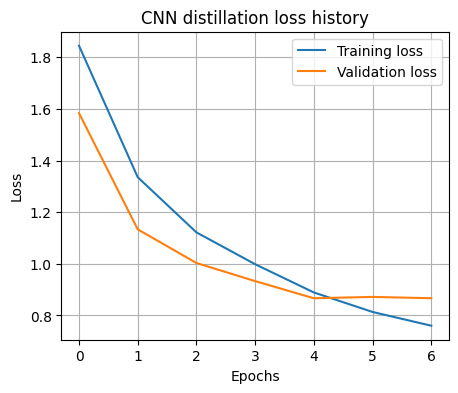

In [ ]:
train_history, val_history = get_train_val_history(trainer_distillation)
plot_learning_curve(train_history, val_history, 'CNN distillation')

##For alppha = 0.0 and T = 4

In [ ]:
results_distillation_cnn2 = trainer_distillation.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,2.675700,1.963975,0.797876,0.797309,0.803683,0.797876
2,1.932300,1.549364,0.837422,0.836752,0.842083,0.837422
3,1.650100,1.428652,0.856951,0.857264,0.859429,0.856951
4,1.448300,1.281255,0.866349,0.866214,0.866312,0.866349
5,1.288500,1.458039,0.838521,0.836756,0.852035,0.838521
6,1.201900,1.125101,0.866227,0.865945,0.866477,0.866227
7,1.103600,1.145046,0.862566,0.862495,0.862474,0.862566


In [ ]:
# Test data
test_results_cnn2 = trainer_distillation.evaluate(test_ds)

# Summary of LSTM results for Test data
cnn_num_params2 = total_num_parameters(cnn_student_model)
print_table(["Model", "Test ACC", "Test F1", "Parameters", "Test Runtime"], [ \
            ['Small RNN', *get_metrics_test(test_results_cnn2), cnn_num_params2, get_runtime(test_results_cnn2)]
           ])

+-----------+----------+---------+------------+--------------+
|   Model   | Test ACC | Test F1 | Parameters | Test Runtime |
+-----------+----------+---------+------------+--------------+
| Small RNN |  0.860   |  0.860  |   3.93 M   |    0m 22s    |
+-----------+----------+---------+------------+--------------+


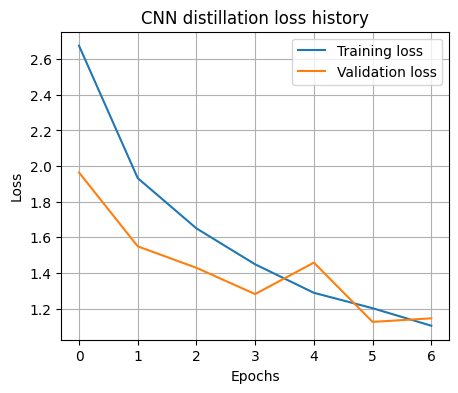

In [ ]:
train_history, val_history = get_train_val_history(trainer_distillation)
plot_learning_curve(train_history, val_history, 'CNN distillation')

##For alppha = 1.0 and T = 1

In [ ]:
results_distillation_cnn3 = trainer_distillation.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,0.771400,0.716435,0.729769,0.728239,0.752235,0.729769
2,0.586700,0.528191,0.815208,0.816176,0.820153,0.815208
3,0.508800,0.540021,0.811913,0.810861,0.825599,0.811913
4,0.451000,0.524018,0.834737,0.834873,0.835762,0.834737
5,0.407800,0.503764,0.829977,0.830161,0.833717,0.829977
6,0.367700,0.578146,0.833761,0.833874,0.837604,0.833761
7,0.348300,0.600984,0.827658,0.826535,0.832726,0.827658


In [ ]:
# Test data
test_results_cnn3 = trainer_distillation.evaluate(test_ds)

# Summary of LSTM results for Test data
cnn_num_params3 = total_num_parameters(cnn_student_model)
print_table(["Model", "Test ACC", "Test F1", "Parameters", "Test Runtime"], [ \
            ['Small RNN', *get_metrics_test(test_results_cnn3), cnn_num_params3, get_runtime(test_results_cnn3)]
           ])

+-----------+----------+---------+------------+--------------+
|   Model   | Test ACC | Test F1 | Parameters | Test Runtime |
+-----------+----------+---------+------------+--------------+
| Small RNN |  0.827   |  0.826  |   3.93 M   |    0m 20s    |
+-----------+----------+---------+------------+--------------+


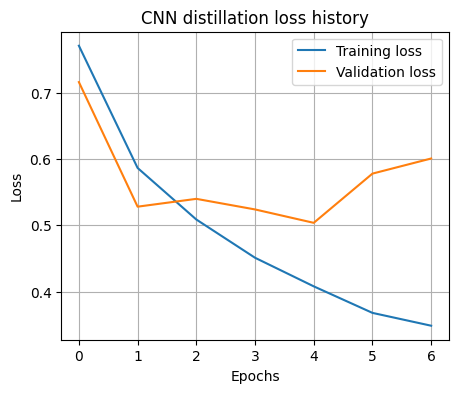

In [ ]:
train_history, val_history = get_train_val_history(trainer_distillation)
plot_learning_curve(train_history, val_history, 'CNN distillation')

In [ ]:
print_table(["Model", "Parameters"], [
            ['CNN student', total_num_parameters(cnn_student_model)]
           ])

+-------------+------------+
|    Model    | Parameters |
+-------------+------------+
| CNN student |   3.93 M   |
+-------------+------------+


**Considering hard and soft targets**

- Hard target -> cross entropy between student predictions and true targets
- Soft target -> distillation loss between student and teacher. This experiment considers the MSE between logits

In [ ]:
vocab_size = config_bert.vocab_size
#embed_size = 64
embed_size = 128
num_classes = 3
dropout = 0.2
batch_size = 32
num_epochs = 10
lr = 5e-3
weight_decay = 1e-3

temperature=0.5
alpha=0.5

cnn_student_model = CNNModel(embed_size, vocab_size, num_classes, dropout, device)

teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_id)


# name for the repository on the hub
repo_name = "distilled-bert-covid-tweets"

#!pip install --upgrade accelerate
training_args = DistillationTrainingArguments(output_dir=repo_name,
                                              num_train_epochs = num_epochs,
                                              evaluation_strategy ="epoch",
                                              save_strategy = "epoch",
                                              per_device_train_batch_size = batch_size,
                                              per_device_eval_batch_size = batch_size,
                                              learning_rate = lr,
                                              load_best_model_at_end=True,
                                              metric_for_best_model="accuracy",
                                              fp16=True,
                                              weight_decay=weight_decay,
                                              #push_to_hub=True,
                                              #hub_model_id=repo_name,
                                              temperature=temperature,
                                              alpha=alpha,
                                              remove_unused_columns=False,
                                              #report_to="wandb"
                                              )


In [ ]:

trainer_distillation = DistillationCNNTrainer(
    cnn_student_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=distill_cnn_collate_fn
)


In [ ]:
results_cnn__distillation = trainer_distillation.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,3.392800,2.860611,0.765898,0.764245,0.770451,0.765898
2,2.484900,2.094110,0.840962,0.840781,0.840742,0.840962
3,2.121900,1.800692,0.847797,0.847018,0.852621,0.847797
4,1.860300,1.665231,0.861345,0.861192,0.861682,0.861345
5,1.698800,1.655614,0.865983,0.866020,0.866454,0.865983
6,1.539900,1.612063,0.862199,0.861817,0.863200,0.862199
7,1.423100,1.583989,0.865983,0.865732,0.866009,0.865983
8,1.308000,1.622732,0.866105,0.865874,0.866235,0.866105


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1938 in _inner_training_loop     │
│                                                                                                  │
│   1935 │   │   │   │   │   self.control = self.callback_handler.on_step_begin(args, self.state,  │
│   1936 │   │   │   │                                                                             │
│   1937 │   │   │   │   with self.accelerator.accumulate(model):                                  │
│ ❱ 1938 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1939 │   │   │   │                                                                             │
│   1940 │   │   │   │   if (                                                                      │
│   1941 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2770 in training_step            │
│                                                                                                  │
│   2767 │   │   │   with amp.scale_loss(loss, self.optimizer) as scaled_loss:                     │
│   2768 │   │   │   │   scaled_loss.backward()                                                    │
│   2769 │   │   else:                                                                             │
│ ❱ 2770 │   │   │   self.accelerator.backward(loss)                                               │
│   2771 │   │                                                                                     │
│   2772 │   │   return loss.detach() / self.args.gradient_accumulation_steps                      │
│   2773                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:1819 in backward               │
│                                                                                                  │
│   1816 │   │   elif self.distributed_type == DistributedType.MEGATRON_LM:                        │
│   1817 │   │   │   return                                                                        │
│   1818 │   │   elif self.scaler is not None:                                                     │
│ ❱ 1819 │   │   │   self.scaler.scale(loss).backward(**kwargs)                                    │
│   1820 │   │   else:                                       

In [ ]:
trainer_distillation.evaluate(train_ds)

{'eval_loss': 1.4819130897521973,
 'eval_accuracy': 0.9011260642680582,
 'eval_f1-score': 0.9010084208026027,
 'eval_precision': 0.9010909913964271,
 'eval_recall': 0.9011260642680582,
 'eval_runtime': 203.299,
 'eval_samples_per_second': 161.186,
 'eval_steps_per_second': 5.042,
 'epoch': 10.0}

###**Considering softmax distillation loss**

- Soft target -> distillation loss between student and teacher. This experiment considers the kl divergence between predicted and true distributions

In [ ]:
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

class DistillationCNNTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        # place teacher on same device as student
        self._move_model_to_device(self.teacher, self.model.device)
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        # Student forward
        outputs_student = model(inputs['input_ids'], inputs['labels'])
        student_loss = outputs_student.loss
        student_logits = outputs_student.get("logits")

        # Teacher forward
        with torch.no_grad():
            teacher_inputs = {'input_ids': inputs['input_ids'],
                              'attention_mask':inputs['attention_mask'],
                              'labels':inputs['labels'] }
            outputs_teacher = self.teacher(**teacher_inputs)
        teacher_logits = outputs_teacher.get("logits")

        # Assert size
        assert student_logits.size() == teacher_logits.size()

        # Soften probabilities and compute distillation loss
        #kl_loss = Losses().distillation_loss_mse(student_logits,teacher_logits)
        kl_loss = Losses().distillation_loss_kl(student_logits, teacher_logits, self.args.temperature)
        # Weighted loss
        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * kl_loss

        return (loss, outputs_student) if return_outputs else loss

In [ ]:
vocab_size = config_bert.vocab_size
#embed_size = 64
embed_size = 128
num_classes = 3
dropout = 0.2
batch_size = 32
num_epochs = 10
lr = 1e-3
weight_decay = 1e-3

temperature=1.0
alpha=0

cnn_student_model = CNNModel(embed_size, vocab_size, num_classes, dropout, device)

teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_id)


# name for the repository on the hub
repo_name = "distilled-bert-covid-tweets"

#!pip install --upgrade accelerate
training_args = DistillationTrainingArguments(output_dir=repo_name,
                                              num_train_epochs = num_epochs,
                                              evaluation_strategy ="epoch",
                                              save_strategy = "epoch",
                                              per_device_train_batch_size = batch_size,
                                              per_device_eval_batch_size = batch_size,
                                              learning_rate = lr,
                                              load_best_model_at_end=True,
                                              metric_for_best_model="accuracy",
                                              fp16=True,
                                              weight_decay=weight_decay,
                                              #push_to_hub=True,
                                              #hub_model_id=repo_name,
                                              temperature=temperature,
                                              alpha=alpha,
                                              remove_unused_columns=False,
                                              report_to="wandb"
                                              )





In [ ]:
wandb.init()
wandb.watch(cnn_student_model)

trainer_distillation = DistillationCNNTrainer(
    cnn_student_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=distill_cnn_collate_fn
)

In [ ]:
results_cnn__distillation = trainer_distillation.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,0.785600,0.712511,0.637373,0.625029,0.634980,0.637373
2,0.660800,0.601717,0.711095,0.711972,0.713204,0.711095
3,0.560900,0.546766,0.754180,0.754539,0.756887,0.754180
4,0.499300,0.508641,0.777615,0.778476,0.782892,0.777615
5,0.440500,0.477890,0.797266,0.797539,0.798459,0.797266
6,0.404600,0.456216,0.810326,0.810465,0.811087,0.810326
7,0.382800,0.444018,0.817161,0.817536,0.818242,0.817161
8,0.355800,0.435553,0.818992,0.819442,0.820323,0.818992
9,0.339200,0.436600,0.819236,0.819431,0.819725,0.819236
10,0.323000,0.435807,0.820456,0.820657,0.820994,0.820456


In [ ]:
trainer_distillation.evaluate(train_ds)

{'eval_loss': 0.23090681433677673,
 'eval_accuracy': 0.906924227165919,
 'eval_f1-score': 0.9069621960022338,
 'eval_precision': 0.9070736965622243,
 'eval_recall': 0.906924227165919,
 'eval_runtime': 201.9572,
 'eval_samples_per_second': 162.257,
 'eval_steps_per_second': 5.075,
 'epoch': 10.0}

In [ ]:
trainer_distillation.evaluate(val_ds)

{'eval_loss': 0.43580734729766846,
 'eval_accuracy': 0.8204564872452094,
 'eval_f1-score': 0.8206567589310475,
 'eval_precision': 0.8209944335679467,
 'eval_recall': 0.8204564872452094,
 'eval_runtime': 50.8285,
 'eval_samples_per_second': 161.189,
 'eval_steps_per_second': 5.056,
 'epoch': 10.0}

In [ ]:
wandb.finish()

eval/accuracy,▁▃▄▅▅▅▆▆▆▆█▆
eval/f1-score,▁▃▄▅▅▆▆▆▆▆█▆
eval/loss,█▆▆▅▅▄▄▄▄▄▁▄
eval/precision,▁▃▄▅▅▆▆▆▆▆█▆
eval/recall,▁▃▄▅▅▅▆▆▆▆█▆
eval/runtime,▁▁▁▁▁▁▁▁▁▁█▁
eval/samples_per_second,▂▃▆▆▄▆█▄▂▄▅▁
eval/steps_per_second,▂▄▆▆▄▆█▄▂▄▃▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
